In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
diago = torch.arange(20).reshape(2, 10)
diago

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

In [4]:
torch.diag_embed(diago)

tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  5,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  6,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9]],

        [[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, 13,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0, 18,  0],
         [ 0,  0,  0,  0,  0,

## Circular CNN 1D

Set easier weights and input vector for easy visualisation

In [5]:
n_in = 10
kernel_size = 5
dilation = 2
padding_mode = "circular"
conv_layer_simple = torch.nn.Conv1d(
    1,
    1,
    kernel_size,
    padding=(kernel_size // 2) * dilation,
    dilation=dilation,
    padding_mode=padding_mode,
    bias=False,
)
# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
conv_layer_simple.weight = torch.nn.Parameter(torch.ones_like(conv_layer_simple.weight))
x = torch.rand(size=(1, 1, 10))
for i in range(n_in):
    x[:, :, i] = 1.0 * i + 1
print(x, x.shape)
print(conv_layer_simple(x), conv_layer_simple(x).shape)


# conv_layer_simple = torch.nn.Conv1d(1, 1, kernel_size, padding=kernel_size//2, dilation=3, padding_mode=padding_mode, bias=False)
# # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
# # conv_layer_simple.weight = torch.nn.Parameter(torch.ones_like(conv_layer_simple.weight))
# print(x)
# print(conv_layer_simple(x))
conv_layers_dilations = []
for dilation in [1, 2, 4]:
    conv_layers_dilations.append(
        torch.nn.Conv1d(
            1,
            1,
            kernel_size,
            padding=(kernel_size // 2) * dilation,
            dilation=dilation,
            padding_mode=padding_mode,
            bias=False,
        )
    )


class ParallelConv1DDilations(torch.nn.Module):
    def __init__(self, n_in, dilation_list, kernel_size):
        self.n_in = n_in
        self.dilation_list = dilation_list
        self.kernel_size = kernel_size
        self.conv_layers_dilations = []
        for dilation in self.dilation_list:
            self.conv_layers_dilations.append(
                torch.nn.Conv1d(
                    1,
                    1,
                    self.kernel_size,
                    padding=(self.kernel_size // 2) * dilation,
                    dilation=dilation,
                    padding_mode=padding_mode,
                    bias=False,
                )
            )

    def forward(self, x):
        return torch.concatenate(
            [conv_layer.forward(x) for conv_layer in self.conv_layers_dilations], dim=1
        )
        

tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]]) torch.Size([1, 1, 10])
tensor([[[25., 30., 25., 30., 25., 30., 25., 30., 25., 30.]]],
       grad_fn=<ConvolutionBackward0>) torch.Size([1, 1, 10])


In [6]:
parconv = ParallelConv1DDilations(10, [1, 2, 4], kernel_size=3)
x = torch.rand((2, 1, 10))
parconv.forward(x)
# parconv.conv_layers_dilations[0](x)

tensor([[[ 0.4299,  0.3688,  0.5398,  0.7141,  0.6581,  0.8938,  0.7079,
           0.7749,  0.8156,  0.5879],
         [-0.0438, -0.2657, -0.0893, -0.1023, -0.4766, -0.1567, -0.2975,
          -0.3517, -0.4367, -0.2881],
         [-0.1427, -0.3179, -0.3673, -0.2116, -0.4528, -0.3101, -0.2970,
          -0.3614, -0.4629, -0.2918]],

        [[ 0.4660,  0.6333,  0.8774,  0.8845,  0.7050,  0.5118,  0.8819,
           0.8486,  0.7146,  0.4169],
         [-0.0149, -0.1157, -0.5046, -0.3921, -0.0764, -0.2854, -0.3283,
          -0.4495, -0.2502, -0.2651],
         [-0.2370, -0.3376, -0.4923, -0.4693, -0.0973, -0.3303, -0.4750,
          -0.5025, -0.2038, -0.2931]]], grad_fn=<CatBackward0>)

In [7]:
conv_layer_vec = torch.nn.Conv1d(1, 5, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True)
layers_vec = torch.nn.Sequential(conv_layer_vec, torch.nn.Conv1d(5, 5, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True))

In [8]:
conv_layer_val = torch.nn.Conv1d(1, 1, kernel_size, padding=kernel_size//2, padding_mode=padding_mode, bias=True)
layers_val = torch.nn.Sequential(conv_layer_val, torch.nn.Flatten(), torch.nn.Linear(n_in, 5))

In [9]:
def construct_conv1D(n_in, n_c, kernel_size):
    padding_mode = 'circular'

    layers_vec = torch.nn.Sequential(
        torch.nn.Conv1d(
            1, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),        
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        )
    )
    return layers_vec

def construct_conv1D_singularvalue(n_in, n_c, kernel_size):
    padding_mode = 'circular'
    layers_vec = torch.nn.Sequential(
        torch.nn.Conv1d(
            1, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.LeakyReLU(),
        torch.nn.Conv1d(
            n_c, n_c, kernel_size, padding=kernel_size // 2, padding_mode=padding_mode
        ),
        torch.nn.AdaptiveAvgPool1d(1)
)
    return layers_vec

class ConvLayersSVD(torch.nn.Module):
    def __init__(self, state_dimension, n_latent, kernel_size) -> None:
        super().__init__()
        self.state_dimension = state_dimension
        self.n_latent = n_latent
        self.kernel_size = kernel_size
        self.layers_vec = construct_conv1D(self.state_dimension, self.n_latent, kernel_size=self.kernel_size)
        self.layers_sing = construct_conv1D_singularvalue(self.state_dimension, self.n_latent, kernel_size=self.kernel_size)
    
    def forward(self, x):
        x = torch.atleast_2d(x)
        x = x.view(len(x), 1, -1)
        n_batch = len(x)
        vectors = torch.nn.functional.normalize(self.layers_vec(x), dim=-1)
        # print(vectors.shape)
        singvals = self.layers_sing(x)
        # print(singvals.shape)
        return torch.concat((vectors, singvals.view(n_batch, self.n_latent, 1)), -1).transpose(1, 2)

In [10]:
n_batch = 3

In [11]:
cvlay = ConvLayersSVD(n_in, 5, 3)


In [12]:
cvlay(x)

tensor([[[ 0.2942,  0.3274,  0.2211,  0.3080, -0.2811],
         [ 0.2907,  0.2810,  0.5182,  0.2999, -0.3633],
         [ 0.3293,  0.2503,  0.4435,  0.3172, -0.3614],
         [ 0.2699,  0.3984,  0.0969,  0.3180, -0.3797],
         [ 0.3113,  0.2916,  0.4578,  0.3108, -0.3297],
         [ 0.3428,  0.3134,  0.2535,  0.3288, -0.3240],
         [ 0.3065,  0.3335,  0.1450,  0.3033, -0.2886],
         [ 0.3183,  0.3428,  0.3394,  0.3114, -0.3000],
         [ 0.3337,  0.3553,  0.1707,  0.3408, -0.3017],
         [ 0.3559,  0.2331,  0.1930,  0.3220, -0.1903],
         [ 0.0844, -0.0524, -0.0174,  0.1394, -0.2755]],

        [[ 0.2940,  0.2606,  0.5170,  0.3006, -0.3389],
         [ 0.2797,  0.3810,  0.2685,  0.3050, -0.4163],
         [ 0.2997,  0.3844,  0.2684,  0.3315, -0.3981],
         [ 0.3725,  0.2119,  0.2318,  0.3381, -0.2341],
         [ 0.3020,  0.3187,  0.1641,  0.3029, -0.2447],
         [ 0.2794,  0.2935,  0.5023,  0.2828, -0.3293],
         [ 0.3142,  0.3839,  0.3535,  0.3263, 

In [15]:
from typing import List
class ParallelConv1DDilations(torch.nn.Module):
    def __init__(
        self, n_in, dilation_list: List = [1, 2, 4], kernel_size: int = 3, skip=True
    ):
        super().__init__()
        self.n_in = n_in
        self.padding_mode = "circular"
        self.dilation_list = dilation_list
        self.kernel_size = kernel_size
        self.conv_layers_dilations = []
        self.skip_connection = skip
        for dilation in self.dilation_list:
            self.conv_layers_dilations.append(
                torch.nn.Conv1d(
                    1,
                    1,
                    self.kernel_size,
                    padding=(self.kernel_size // 2) * dilation,
                    dilation=dilation,
                    padding_mode=self.padding_mode,
                    bias=False,
                )
            )

    def forward(self, x):
        forw = [conv_layer.forward(x) for conv_layer in self.conv_layers_dilations]
        forw.append(x)
        return torch.concatenate(forw, dim=1)


In [19]:
conv = ParallelConv1DDilations(1)


RuntimeError: Invalid padding size, expected 0 but got 2

In [ ]:
print(f"{x.shape=}, {y.shape=}")
print(f"{x.shape=}, {layers_vec(x).shape=}")
print(f"{x.shape=}, {layers_val(x).shape=}")
y, z = layers_vec(x), layers_val(x)
y.shape, z.shape


x.shape=torch.Size([3, 1, 10]), y.shape=torch.Size([3, 10, 5])
x.shape=torch.Size([3, 1, 10]), layers_vec(x).shape=torch.Size([3, 5, 10])
x.shape=torch.Size([3, 1, 10]), layers_val(x).shape=torch.Size([3, 5])


(torch.Size([3, 5, 10]), torch.Size([3, 5]))

torch.Size([3, 11, 5])

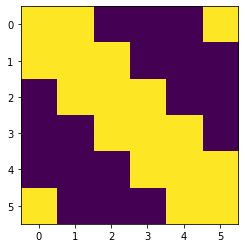

In [ ]:
conv_matrix = torch.zeros((n_in, n_in))
for i in range(n_in):
    conv_matrix[i, i % n_in] = 1.0
    for j in range(kernel_size):
        conv_matrix[i, (i+j - kernel_size//2) % n_in] = 1.0
plt.imshow(conv_matrix)

In [ ]:
(conv_matrix @ x.squeeze() == y).all()

tensor(True)

In [ ]:
print(x)
print(y)

tensor([[[0., 1., 2., 3., 4., 5.]]])
tensor([[[ 6.,  3.,  6.,  9., 12.,  9.]]], grad_fn=<SqueezeBackward1>)


## Self Attention Layer

In [ ]:
embed_dim = 1

In [ ]:
attention_layer = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1)